# *Well-mixed* agent-based simulations w. vaccine hesitancy and assortativity

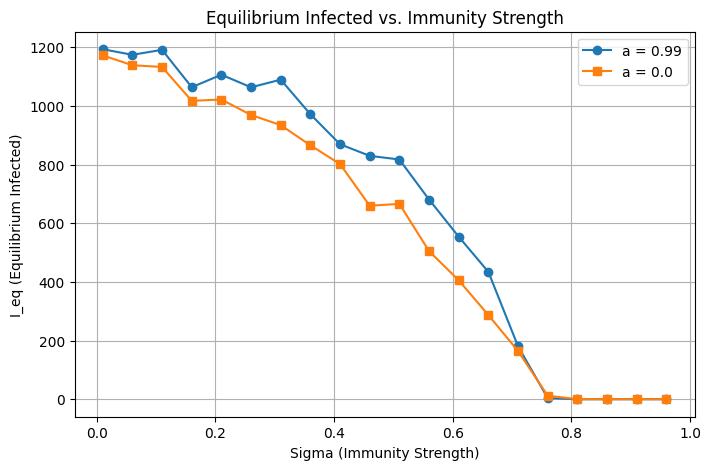

In [4]:
import numpy as np
import random
import matplotlib.pyplot as plt
from concurrent.futures import ProcessPoolExecutor, as_completed
from numba import njit

@njit
def simulate_one_run(params):
    beta = params["beta"]
    a = params["a"]
    sigma = params["sigma"]
    gamma = params["gamma"]
    
    N = 2000
    frac_vaccinated = 0.7
    contacts_per_infected = 1
    dt = 0.5
    timesteps = int(200/dt)
    
    vaccinated = np.random.rand(N) < frac_vaccinated
    state = np.zeros(N, dtype=np.int64)
    ## 2 = vaccinated and recovered, 1 = infected, 0 = susceptible
    state[vaccinated] = 2
    
    unvaccinated_indices = np.where(~vaccinated)[0]
    initial_infected = np.random.choice(unvaccinated_indices)
    state[initial_infected] = 1
    
    I_history = []
    
    for t in range(timesteps):
        new_state = state.copy()
        infected_indices = np.where(state == 1)[0]
        
        for i in infected_indices:
            v_status = vaccinated[i]
            f_same = np.sum(vaccinated == v_status) / N
            p_same = f_same + a * (1 - f_same) if a >= 0 else f_same + a * f_same
            
            for _ in range(contacts_per_infected):
                if random.random() < p_same:
                    candidates = np.where(vaccinated == v_status)[0]
                else:
                    candidates = np.where(vaccinated != v_status)[0]
                
                candidates = candidates[candidates != i]
                if len(candidates) == 0:
                    continue
                contact = np.random.choice(candidates)
                
                if state[contact] == 0:
                    if random.random() < beta * dt:
                        new_state[contact] = 1
                elif state[contact] == 2:
                    effective_beta = (1.0 - sigma) * beta
                    if random.random() < effective_beta * dt:
                        new_state[contact] = 1
        
        ## Recoveries
        for i in infected_indices:
            if random.random() < gamma * dt:
                new_state[i] = 2
        
        state = new_state.copy()
        I_history.append(np.sum(state == 1))
    
    peak_infected = max(I_history)
    outbreak = peak_infected >= 20
    I_eq = I_history[-1]  # Equilibrium number after timestep 100
    
    return I_eq, outbreak

def run_simulations_for_sigma(params, num_simulations=200, max_workers=20):
    results = []
    with ProcessPoolExecutor(max_workers=max_workers) as executor:
        futures = [executor.submit(simulate_one_run, params) for _ in range(num_simulations)]
        for future in as_completed(futures):
            results.append(future.result())
    return results

param_dtype = np.dtype([
    ('beta', np.float64),
    ('a', np.float64),
    ('sigma', np.float64),
    ('gamma', np.float64),
])

params = np.zeros(1, dtype=param_dtype)[0]
params["beta"] = 0.8
params["gamma"] = 0.2

sigmas = np.arange(0.01, 1.01, 0.05)
I_eq_values_all_1 = []
I_eq_values_all_2 = []
I_eq_values_when_outbreak_1 = []
I_eq_values_when_outbreak_2 = []
asso_1 = 0.99
asso_2 = 0.00

for sigma in sigmas:
    params["sigma"] = sigma
    params["a"] = asso_1
    results_1 = run_simulations_for_sigma(params, num_simulations=200)
    I_eq_values_all_1.append(np.mean([I_eq for I_eq, outbreak in results_1]))
    I_eq_1 = np.mean([I_eq for I_eq, outbreak in results_1 if outbreak])
    I_eq_values_when_outbreak_1.append(I_eq_1)

    params["a"] = asso_2
    results_2 = run_simulations_for_sigma(params, num_simulations=200)
    I_eq_values_all_2.append(np.mean([I_eq for I_eq, outbreak in results_2]))
    I_eq_2 = np.mean([I_eq for I_eq, outbreak in results_2 if outbreak])
    I_eq_values_when_outbreak_2.append(I_eq_2)

plt.figure(figsize=(8, 5))
plt.plot(sigmas, I_eq_values_all_1, label=f"a = {asso_1}", marker='o')
plt.plot(sigmas, I_eq_values_all_2, label=f"a = {asso_2}", marker='s')
plt.xlabel("Sigma (Immunity Strength)")
plt.ylabel("I_eq (Equilibrium Infected)")
plt.title("Equilibrium Infected vs. Immunity Strength")
plt.legend()
plt.grid()
plt.show()


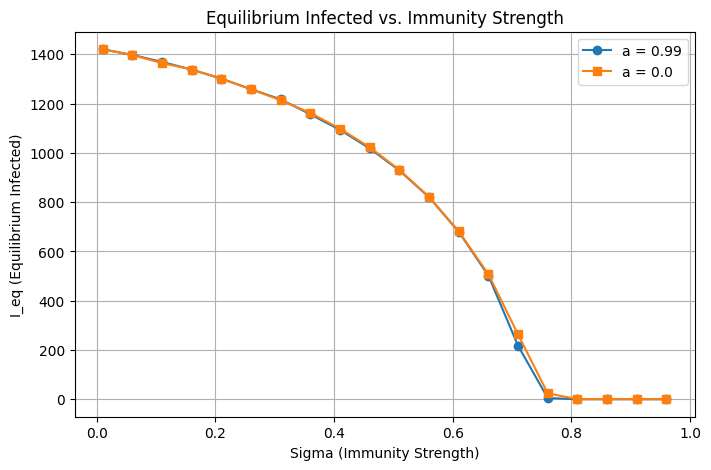

In [6]:
plt.figure(figsize=(8, 5))
plt.plot(sigmas, I_eq_values_when_outbreak_1, label=f"a = {asso_1}", marker='o')
plt.plot(sigmas, I_eq_values_when_outbreak_2, label=f"a = {asso_2}", marker='s')
plt.xlabel("Sigma (Immunity Strength)")
plt.ylabel("I_eq (Equilibrium Infected)")
plt.title("Equilibrium Infected vs. Immunity Strength")
plt.legend()
plt.grid()
plt.show()


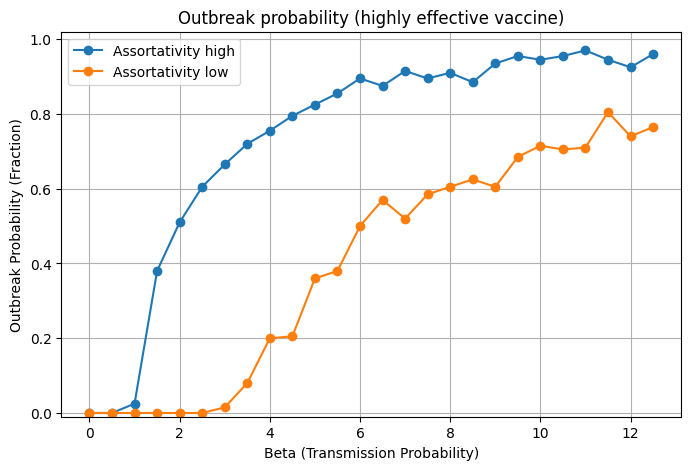

In [4]:

# -------------------------
# Plotting the Results 1 # recall that the sigma parameter controls the strength of immunity (vaccinated/recovered)
# -------------------------
plt.figure(figsize=(8, 5))
plt.figure(figsize=(8, 5))
plt.plot(sigmas, outbreak_probabilities_1, label='Assortativity = 0.99')
plt.plot(sigmas, outbreak_probabilities_2, label='Assortativity = 0.00')
plt.xlabel('Vaccine Effectiveness (Sigma)')
plt.ylabel('Outbreak Probability')
plt.title('Outbreak Probability vs Sigma')

plt.plot(np.array(betas)/params["gamma"], outbreak_probabilities_1, marker='o', linestyle='-', label=f"Assortativity high")
plt.plot(np.array(betas)/params["gamma"], outbreak_probabilities_2, marker='o', linestyle='-', label=f"Assortativity low")
plt.xlabel("Beta (Transmission Probability)")
plt.ylabel("Outbreak Probability (Fraction)")
if params["sigma"] > 0.9:
    plt.title("Outbreak probability (highly effective vaccine)")
else:
    plt.title("Outbreak probability (moderately effective vaccine)")
plt.grid(True)
plt.ylim([-0.01, 1.02])
plt.legend()